In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Counts')

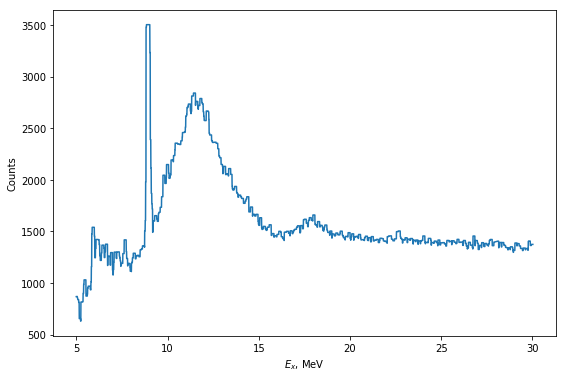

In [2]:
Ga_5_28 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/5_28.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(Ga_5_28['x'].values, Ga_5_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.ylim(0,6)

Text(0,0.5,'Counts')

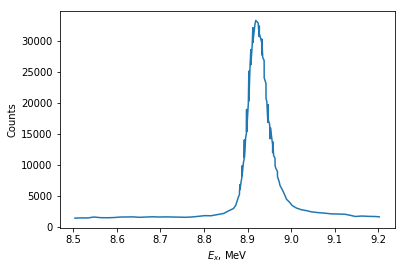

In [3]:
IAS = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/IAS.csv', 
                      sep='\t', decimal=',')
IAS['y'] = IAS['y'] * 1000
plt.plot(IAS['x'].values, IAS['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.xlim(8.9,9)

Text(0,0.5,'Counts')

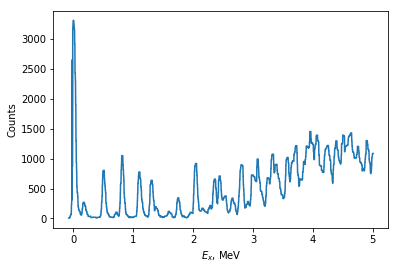

In [4]:
Ga_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/0_5.csv', 
                      sep='\t', decimal=',')
plt.plot(Ga_0_5['x'].values, Ga_0_5['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

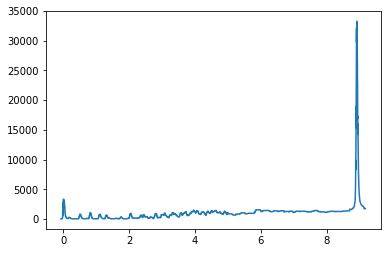

In [5]:
beginning = Ga_5_28[((Ga_5_28['x']<8.7))]
middle = IAS[((IAS['x']>8.7) & (IAS['x']<9.18))]
#ending = Ga_5_28[((Ga_5_28['x']>9.18) & (Ga_5_28['x']<9.5))]
ending = Ga_5_28[((Ga_5_28['x']>9.18))]

#data = Ga_0_5.append(beginning).append(middle).append(ending)
data = Ga_0_5.append(beginning).append(middle)

plt.plot(data['x'].values, data['y'].values)

(0, 20)

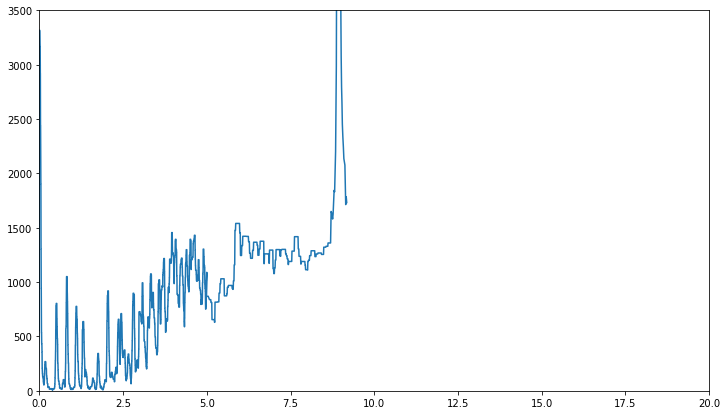

In [6]:
plt.figure(figsize=(12,7))
plt.plot(data['x'].values, data['y'].values)
plt.ylim(0,3500)
plt.xlim(0,20)

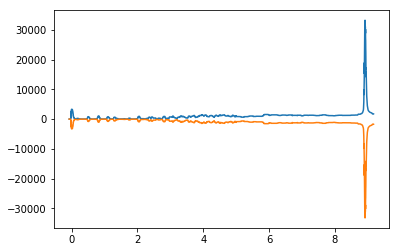

In [7]:
plt.plot(data['x'].values, data['y'].values)
plt.plot(data['x'].values, -data['y'].values)

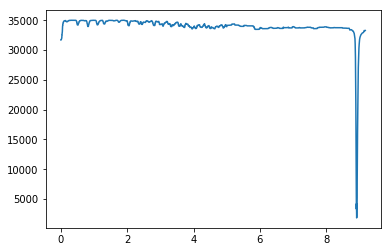

In [8]:
x_data = np.linspace(0,9.18,len(data['x'].values))
y_data = np.interp(x_data, data['x'].values, data['y'].values)
#plt.plot(x_data, y_data)
plt.plot(x_data, -y_data+35000)

(0, 5000)

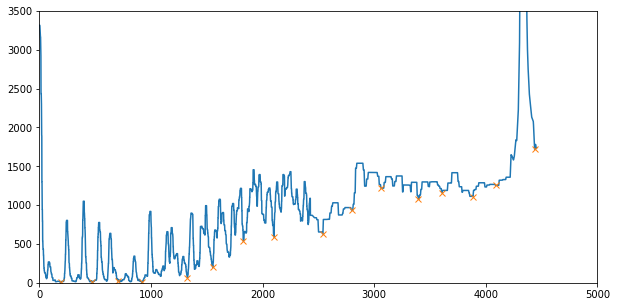

In [9]:
peaks, _ = sc.signal.find_peaks(-y_data+35000, distance=201)
plt.figure(figsize=(10,5))
plt.plot(y_data)
plt.plot(peaks, y_data[peaks], "x")
plt.ylim(0,3500)
plt.xlim(0,5000)

(8.7, 9.2)

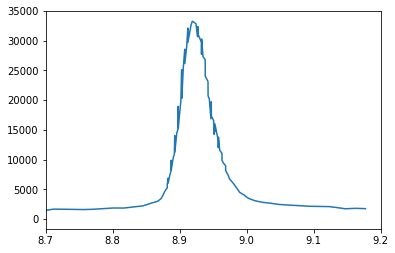

In [10]:
plt.plot(data['x'].values, data['y'].values)
plt.xlim(8.7,9.2)

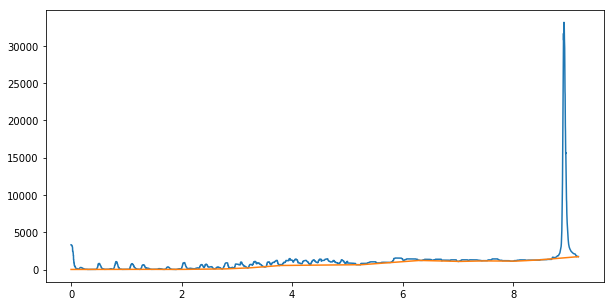

In [11]:
y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(x_data, y_data2)
#plt.xlim(8.5,9.2)

(0, 3.5)

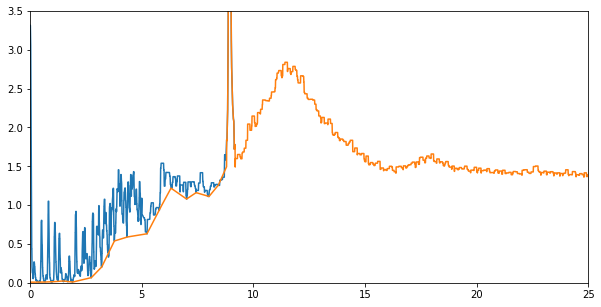

In [12]:
temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})

data3 = temp2[(temp2['x']<8.8)].append(temp1[((temp1['x']>8.8) & (temp1['x']<9.18))]).append(ending)
data4 = Ga_0_5.append(beginning).append(middle).append(ending)


temp1['y'] = temp1['y'] / 1000
temp2['y'] = temp2['y'] / 1000
data3['y'] = data3['y'] / 1000
data4['y'] = data4['y'] / 1000

plt.figure(figsize=(10,5))
plt.plot(temp1['x'].values, temp1['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(data4['x'].values, data4['y'].values, ls='--')
plt.xlim(0,25)
plt.ylim(0,3.5)

In [13]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [14]:
def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_71Ge=0.232
    S_p_71Ge=8.285
    E_t_gs = 420 - Q_EC_71Ge
    E_0 = E_t_gs - S_p_71Ge
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [15]:
#np.random.seed(150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='T1_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back4, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=4.5, min=3, max=5)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=5)

total_mod.set_param_hint('pigmy2_w', value=6, min=4, max=8)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=5)

total_mod.set_param_hint('IAS1_w', value=8.913, min=8.8, max=9.1) #возможно ошибка в оцифровке, если фиксировать значение, то пик получается смещенным
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.04)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=5)

total_mod.set_param_hint('GTR_w', value=11.75, min=11, max=13)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 10)

total_mod.set_param_hint('T1_w', value=18, min=17.8, max=18.2)
total_mod.set_param_hint('T1_G1', value=1, min=0.1, max=1)
total_mod.set_param_hint('T1_M', value=0.5, min=0.1, max=3)

total_mod.set_param_hint('SDR_w', value=22, min=18, max=30)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=8)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max=0.5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, min=1, max=15 )

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='T1_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back4, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 30952
    # data points      = 7197
    # variables        = 20
    chi-square         = 305.772
    reduced chi-square = 0.043
    Akaike info crit   = -22692.307
    Bayesian info crit = -22554.678
[[Variables]]
    pigmy1_M:        0.14221613 (init= 5)
    pigmy1_w:        4.11756406 (init= 4.5)
    pigmy1_G1:       0.42180326 (init= 0.1)
    pigmy2_M:        0.73413596 (init= 1)
    pigmy2_w:        6.43395567 (init= 6)
    pigmy2_G1:       0.99772287 (init= 0.1)
    IAS1_M:          0.73936126 (init= 0.5)
    IAS1_w:          8.92344009 (init= 8.913)
    IAS1_G1:         0.02210625 (init= 0.01)
    GTR_M:           5.57487789 (init= 0.5)
    GTR_

(0, 3.5)

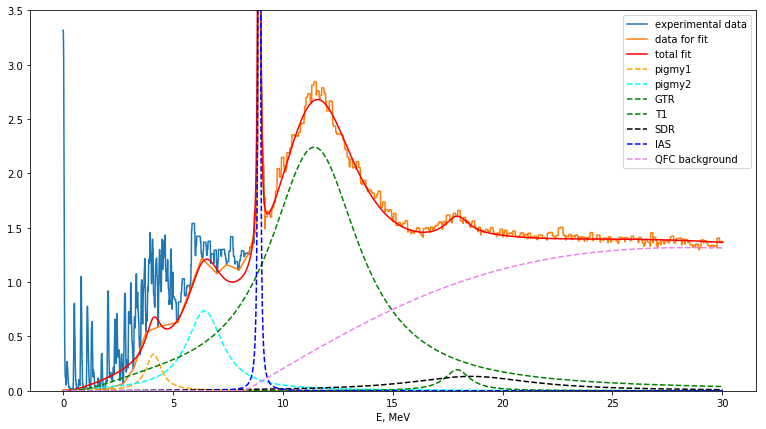

In [16]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(temp1['x'].values, temp1['y'].values, label='experimental data')
plt.plot(data3['x'].values, data3['y'].values, label='data for fit')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'g--', label='T1')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3.5)

(0, 30)

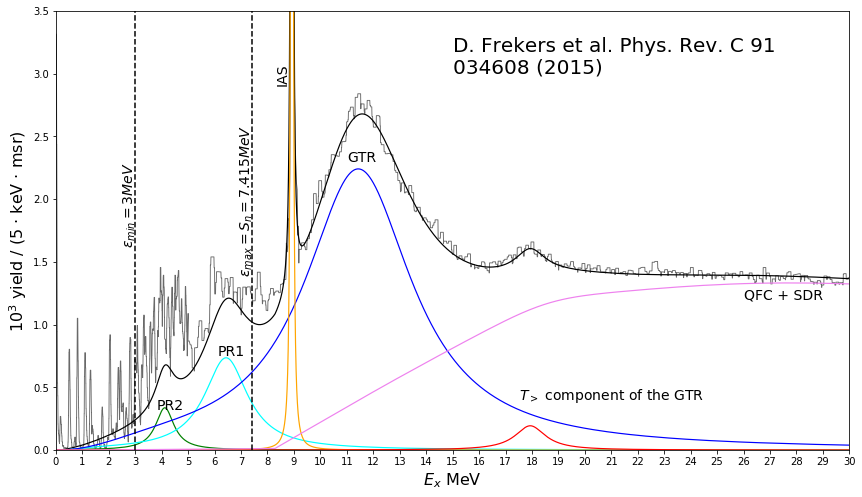

In [17]:
total_mod_comps = total_mod_result.eval_components()

QFCSDR = total_mod_comps['SDR_'] + total_mod_comps['QFC_back_']

plt.figure(figsize=(12,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'green', label='PR2', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='PR1', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'blue', label='GTR', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'orange', label='IAS ', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'red', label='$T_{>}$ component of the GTR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, QFCSDR, 'violet', label='QFC + SDR', ls='-', linewidth=1.2)

plt.text(11, 2.3, 'GTR',  fontsize=14)
plt.text(26, 1.2, 'QFC + SDR',  fontsize=14)
plt.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
plt.text(8.3, 3.0, 'IAS',  fontsize=14, rotation=90)
plt.text(6.1, 0.75, 'PR1',  fontsize=14)
plt.text(3.8, 0.32, 'PR2',  fontsize=14)
plt.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
plt.axvline(3, c='black', ls='--',)
plt.axvline(S_n, c='black', ls='--',)
plt.text(2.5, 2.2, '$\epsilon_{min}=3 MeV$', rotation=90, fontsize=14)
plt.text(S_n-0.5, 2.5, '$\epsilon_{max}=S_{n}=7.415 MeV$', rotation=90, fontsize=14)

#plt.legend()
plt.xlabel('$E_{x}$ MeV', fontsize=16)
plt.ylabel('$10^{3}$ yield / (5 $\cdot$ keV $\cdot$ msr)', fontsize=16)
plt.xticks(np.arange(0, 31, step=1))
plt.tight_layout()
plt.ylim(0,3.5)
plt.xlim(0,30)
#plt.savefig('ga_decomposition.png', format='png', dpi=500)

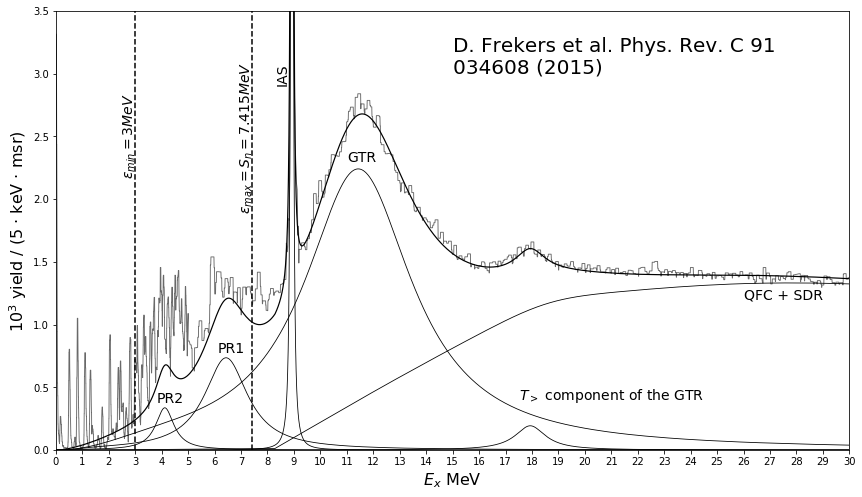

In [31]:
total_mod_comps = total_mod_result.eval_components()

QFCSDR = total_mod_comps['SDR_'] + total_mod_comps['QFC_back_']

plt.figure(figsize=(12,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data4['x'].values, data4['y'].values, 'dimgrey', linewidth=0.9, label='Experimental data \nD. Frekers et al. PHYSICAL REVIEW C 91, 034608 (2015)')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', ls='-', label='Total fit',  linewidth=1.2)
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='PR2', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='PR1', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'k', label='IAS ', ls='-', linewidth=0.8)
plt.plot(data3['x'].values, total_mod_comps['T1_'], 'k', label='$T_{>}$ component of the GTR', ls='-', linewidth=0.8)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'y', label='SDR', ls='-', linewidth=1.2)
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='-', linewidth=1.2)
plt.plot(data3['x'].values, QFCSDR, 'k', label='QFC + SDR', ls='-', linewidth=0.8)

plt.text(11, 2.3, 'GTR',  fontsize=14)
plt.text(26, 1.2, 'QFC + SDR',  fontsize=14)
plt.text(17.5, 0.4, '$T_{>}$ component of the GTR',  fontsize=14)
plt.text(8.3, 3.0, 'IAS',  fontsize=14, rotation=90)
plt.text(6.1, 0.78, 'PR1',  fontsize=14)
plt.text(3.8, 0.38, 'PR2',  fontsize=14)
plt.text(15, 3, 'D. Frekers et al. Phys. Rev. C 91\n034608 (2015)',  fontsize=20)

S_n = 7.415
plt.axvline(3, c='black', ls='--',)
plt.axvline(S_n, c='black', ls='--',)
plt.text(2.5, 2.75, '$\epsilon_{min}=3 MeV$', rotation=90, fontsize=14)
plt.text(S_n-0.5, 3.0, '$\epsilon_{max}=S_{n}=7.415 MeV$', rotation=90, fontsize=14)

#plt.legend()
plt.xlabel('$E_{x}$ MeV', fontsize=16)
plt.ylabel('$10^{3}$ yield / (5 $\cdot$ keV $\cdot$ msr)', fontsize=16)
plt.xticks(np.arange(0, 31, step=1))
plt.tight_layout()
plt.ylim(0,3.5)
plt.xlim(0,30)
plt.savefig('ga_decomposition.png', format='png', dpi=500)

(8.5, 9.2)

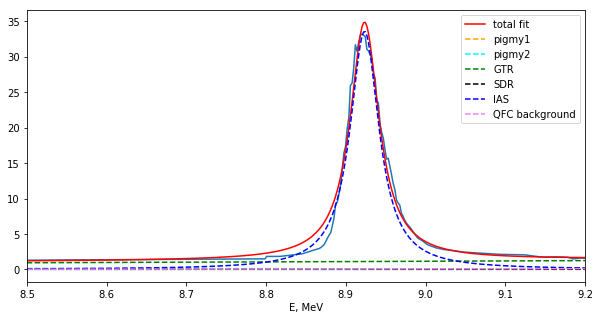

In [52]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xlim(8.5,9.2)

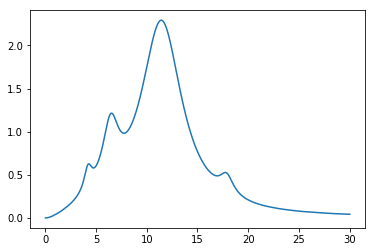

In [53]:
output = pd.DataFrame(data={'x':data3['x'].values, 'y':total_mod_comps['pigmy1_']+
                           total_mod_comps['pigmy2_']+total_mod_comps['GTR_']+
                           total_mod_comps['T1_']})

plt.plot(output['x'].values, output['y'].values)
plt.show()

In [54]:
#output.to_csv('71Ga_2PR.csv')